# **🏷️ Sales forecasting: melhoria de previsões com machine learning**

# 💡 1. Introdução

A previsão de vendas é uma atividade essencial para empresas de varejo, pois impacta diretamente na gestão de estoque, planejamento de compras e maximização de receitas. Prever com precisão permite reduzir desperdícios, evitar rupturas e tomar decisões estratégicas com base em dados.

Este projeto foi pensado para refletir um desafio comum enfrentado por empresas no setor de varejo, que é a necessidade de estimativas mais precisas para embasar decisões estratégicas de estoque, logística e marketing. A base de dados utilizada é proveniente da competição ["Store Sales - Time Series Forecasting"](https://www.kaggle.com/competitions/store-sales-time-series-forecasting) do Kaggle, e contém registros diários de vendas, informações sobre produtos, lojas, promoções e feriados.

## 1.1 Contextualização do problema

A empresa atualmente utiliza o modelo SARIMA para prever as vendas diárias de seus produtos. Embora esse modelo tenha se mostrado útil, a área de negócios levantou preocupações:

* Estamos conseguindo prever com precisão suficiente para tomar decisões logísticas e de estoque?

* É possível melhorar o modelo atual com técnicas mais modernas?

* Quais ganhos reais isso traria para a operação da empresa?

Como cientista de dados, fui incumbido de investigar essas questões. Para isso, foi preciso avaliar o desempenho do modelo atual e propor alternativas que gerem previsões mais precisas e confiáveis.

## 1.2 Modelos avaliados


Para testar possíveis melhorias na acurácia das previsões, comparei três modelos:

* SARIMA (modelo tradicional da empresa)

* Prophet (modelo automatizado de séries temporais do Facebook)

* XGBoost (modelo de machine learning supervisionado, ajustado com variáveis de calendário, promoção e contexto econômico)

Todos os modelos foram avaliados com base em dados históricos de vendas, considerando as seguintes métricas:

* Correlação entre previsto e observado

* Viés absoluto e percentual

* RMSE (Erro Quadrático Médio)

* RMSLE (Erro Logarítmico Quadrático Médio)

# 🗃️ 2. Aquisição dos dados

Importando bibliotecas necessárias.

In [1]:
import pandas as pd

In [2]:
sales = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
oil = pd.read_csv('oil.csv')
holidays = pd.read_csv('holidays_events.csv')

Visualizando os dataframes importados

In [3]:
sales.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [5]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [6]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [7]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [8]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


Aqui podemos notar que o df oil possui valores nulos que deverão ser tratados posteriormente.

In [9]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [10]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


## 2.1 Pré-processamento

Como vimos na etapa anterior, é preciso converter as colunas 'date' para o tipo datetime e também tratar os dados nulos do df oil.

In [11]:
sales['date'] = pd.to_datetime(sales['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])


In [12]:
print("Valores nulos em 'sales':\n", sales.isnull().sum())
print("Valores nulos em 'stores':\n", stores.isnull().sum())
print("\nValores nulos em 'oil':\n", oil.isnull().sum())
print("\nValores nulos em 'holidays':\n", holidays.isnull().sum())


Valores nulos em 'sales':
 id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
Valores nulos em 'stores':
 store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

Valores nulos em 'oil':
 date           0
dcoilwtico    43
dtype: int64

Valores nulos em 'holidays':
 date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64


Aqui podemos confirmar que apenas oil possui valores nulos. Iremos fazer a interpolação desses dados pelo método linear.

In [13]:
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(method='linear', limit_direction='both')

In [14]:
print("\nValores nulos em 'oil':\n", oil.isnull().sum())


Valores nulos em 'oil':
 date          0
dcoilwtico    0
dtype: int64


A partir da coluna 'date', iremos criar as variáveis temporais ano ('year'), mês ('month'), dia ('day'), dia da semana ('day_of_week') e uma variável booleana para classificar como final de semana ou não ('is_weekend').

In [15]:
# Criar variáveis temporais
sales['year'] = sales['date'].dt.year
sales['month'] = sales['date'].dt.month
sales['day'] = sales['date'].dt.day
sales['day_of_week'] = sales['date'].dt.dayofweek
sales['is_weekend'] = sales['day_of_week'].isin([5,6])  # sábado e domingo


In [16]:
sales.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,is_weekend
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,False
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,False
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,False
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,False


Agora iremos unir as informações sobre as lojas e o valor do petróleo ao df principal (sales). Do df store_nbr iremos precisar da coluna 'cluster', que representa um agrupamento de lojas semelhantes.

In [17]:
sales = sales.merge(stores[['store_nbr', 'cluster']], on='store_nbr', how='left')
sales.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,is_weekend,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,False,13
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,False,13
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,False,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,False,13
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,False,13


Em seguida, iremos adicionar o preço do petróleo.

In [18]:
sales = sales.merge(oil[['date', 'dcoilwtico']], on='date', how='left')
sales.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,is_weekend,cluster,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,False,13,93.14
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,False,13,93.14
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,False,13,93.14
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,False,13,93.14
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,False,13,93.14


Após o merge, precisamos verificar se ficaram linhas com valores nulos.

In [19]:
print("Valores nulos em 'sales':\n", sales.isnull().sum())

Valores nulos em 'sales':
 id                  0
date                0
store_nbr           0
family              0
sales               0
onpromotion         0
year                0
month               0
day                 0
day_of_week         0
is_weekend          0
cluster             0
dcoilwtico     857142
dtype: int64


A coluna referente ao valor do petróleo ('dcoilwtico') apresentou valores nulos, indicando que algumas datas não possuem essa informação. Para tratar isso, iremos novamente fazer a interpolação linear.

In [20]:
sales['dcoilwtico'] = sales['dcoilwtico'].interpolate(method='linear', limit_direction='both')

In [21]:
print("Valores nulos em 'sales':\n", sales.isnull().sum())

Valores nulos em 'sales':
 id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
year           0
month          0
day            0
day_of_week    0
is_weekend     0
cluster        0
dcoilwtico     0
dtype: int64


Para concluir essa etapa, iremos analisar o df holidays.

In [22]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [23]:
print(holidays['locale'].unique())

['Local' 'Regional' 'National']


Como podemos ver, esse df possui feriados locais, regionais e nacionais. Iremos criar um novo df apenas com os feriados nacionais e iremos excluir os feriados que foram transferidos.

In [24]:
holidays_nacionais = holidays[(holidays['locale'] == 'National') & (holidays['transferred'] == False)]
holidays_nacionais.head()

,date,type,locale,locale_name,description,transferred
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
22,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
31,2012-12-21,Additional,National,Ecuador,Navidad-4,False


Agora iremos adicionar a informação referente aos feriados como uma variável booleana no df sales.

In [25]:
sales['is_holiday'] = sales['date'].isin(holidays_nacionais['date'])
sales.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,is_weekend,cluster,dcoilwtico,is_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,False,13,93.14,True
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,False,13,93.14,True
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,False,13,93.14,True
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,False,13,93.14,True
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,False,13,93.14,True


Para termos uma ideia da extensão do nosso df, iremos checar a data inicial e a final, bem como a quantidade de lojas.

In [26]:
print(f'Período dos dados: de {sales['date'].min().date()} até {sales['date'].max().date()}')
print("\nNúmero de lojas:", sales['store_nbr'].nunique())


Período dos dados: de 2013-01-01 até 2017-08-15

Número de lojas: 54


# 🔍 3. Análise exploratória dos dados

Importando bibliotecas necessárias.

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

Inicialmente iremos ver como é a distribuição do total de vendas ao longo do tempo, isso nos dará uma ideia do comportamento dessa série temporal.
Para isso, precisaremos agrupar o df sales pela coluna 'date' e somar os valores da coluna 'sales'.

Além disso, vamos adicionar uma média móvel de 7 dias ao gráfico, o que ajudará a suavizar as variações diárias e a destacar melhor as tendências e sazonalidades da série.

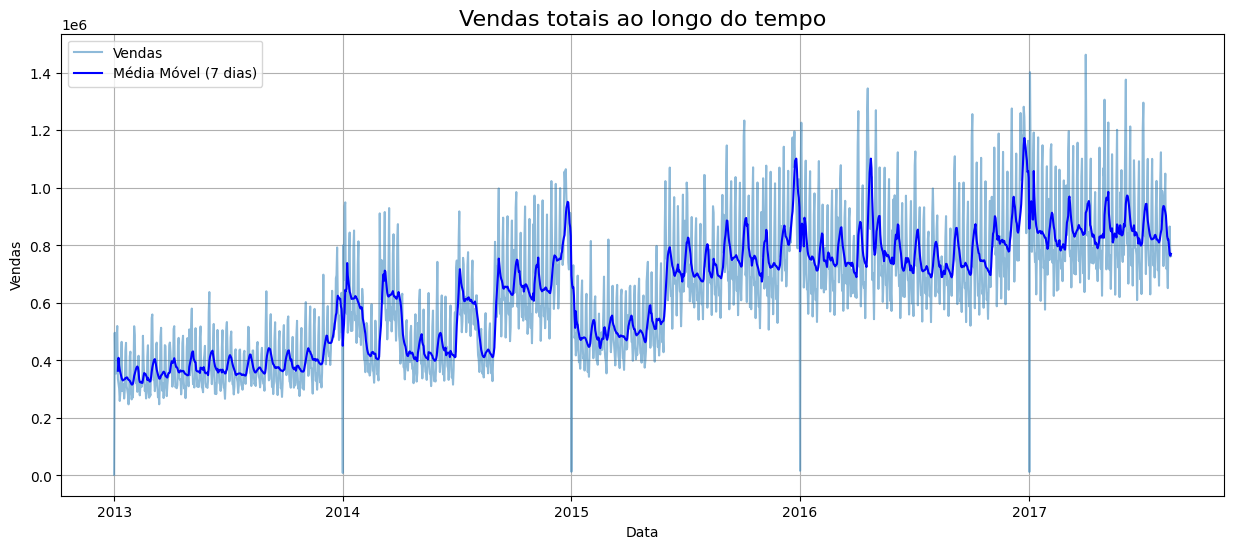

In [28]:
sales_by_date = sales.groupby('date')['sales'].sum().reset_index()

# Calcular média móvel de 7 dias, por exemplo
sales_by_date['media_movel'] = sales_by_date['sales'].rolling(window=7).mean()

# Plotar
plt.figure(figsize=(15,6))
plt.plot(sales_by_date['date'], sales_by_date['sales'], label='Vendas', alpha=0.5)
plt.plot(sales_by_date['date'], sales_by_date['media_movel'], label='Média Móvel (7 dias)', color='blue')
plt.title('Vendas totais ao longo do tempo', fontsize=16)
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()
plt.grid(True)
plt.show()


No gráfico acima, observa-se uma tendência geral de crescimento nas vendas, com variações sazonais regulares e picos de vendas mais pronunciados nos anos posteriores. Há também quedas bruscas e pontuais, sempre no primeiro dia do ano, possivelmente associadas a feriados ou interrupções nas operações. A amplitude das variações aumenta com o tempo, indicando que um modelo multiplicativo pode ser mais adequado para a decomposição dessa série temporal.

Para comparar a venda em feriados e em dias comuns, iremos agrupar o df sales pela coluna 'is_holiday' e calcular a média de vendas.

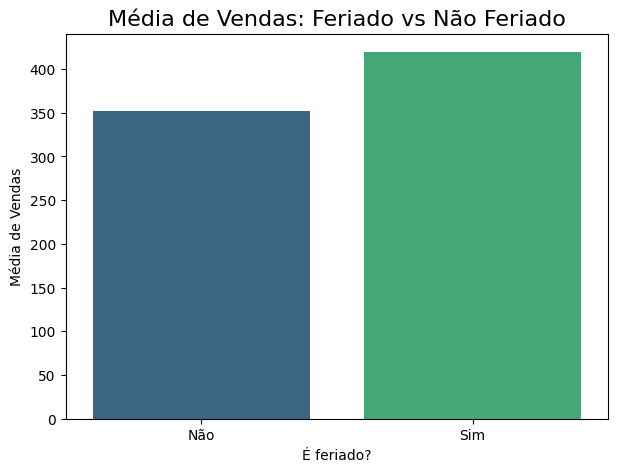

In [29]:
sales_holiday = sales.groupby('is_holiday')['sales'].mean().reset_index()

# Plotar
plt.figure(figsize=(7,5))
sns.barplot(x='is_holiday', y='sales', data=sales_holiday, palette='viridis', hue='is_holiday')
plt.title('Média de Vendas: Feriado vs Não Feriado', fontsize=16)
plt.xlabel('É feriado?')
plt.ylabel('Média de Vendas')
plt.legend().remove()
plt.xticks([0, 1], ['Não', 'Sim'])
plt.show()


Aparentemente existe uma diferença entre a média de vendas em feriados e em dias comuns, sendo esta média maior nos feriados. Entretanto, para fazermos essa afirmação com certeza precisaremos realizar um teste estatístico. Para escolher o teste mais adequado estatisticamente, precisamos ver como é a distribuição das vendas em feriados e em dias comuns. Caso os dados tenham distribuição normal, podemos usar o teste t de Student, caso contrário, precisaremos usar um teste não paramétrico como o teste U de Mann-Whitney.

Para isso, iremos utilizar o df sales_by_date que tem os valores de vendas agrupados por dia e criaremos a coluna 'is_holiday' para saber se o dia é feriado ou não, semelhante ao que fizemos no df sales.

In [30]:
sales_by_date['is_holiday'] = sales_by_date['date'].isin(holidays_nacionais['date'])
sales_by_date = sales_by_date.drop('media_movel', axis=1)
sales_by_date.head()

,date,sales,is_holiday
0,2013-01-01,2511.618999,True
1,2013-01-02,496092.417944,False
2,2013-01-03,361461.231124,False
3,2013-01-04,354459.677093,False
4,2013-01-05,477350.121229,True


Uma vez feito isso, vamos plotar um gráfico de violino que nos permite ver a distribuição dos dados e também tem informações sobre os quartis, como um boxplot.

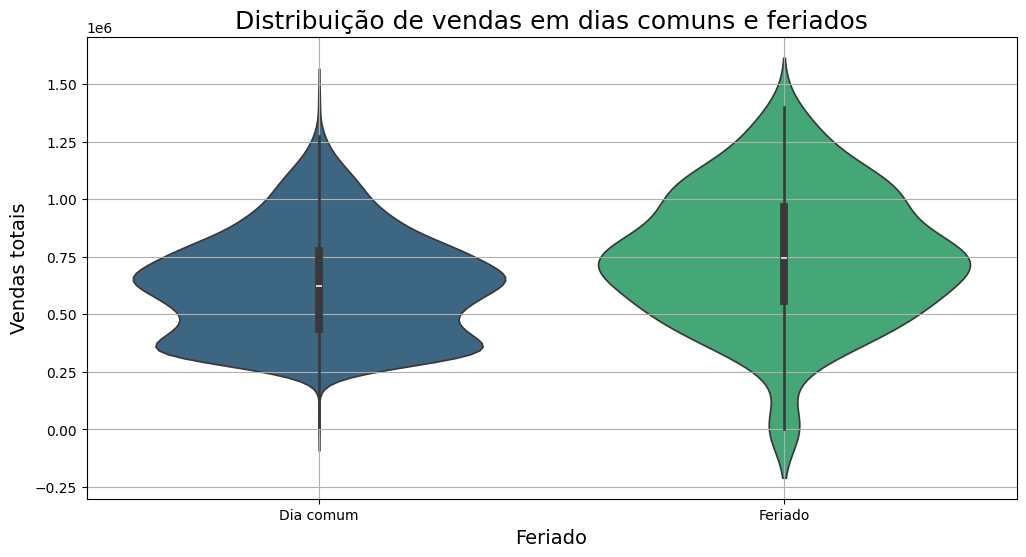

In [31]:
plt.figure(figsize=(12,6))
sns.violinplot(x='is_holiday', y='sales', data=sales_by_date, inner='box', palette='viridis', hue='is_holiday')
plt.title('Distribuição de vendas em dias comuns e feriados', fontsize=18)
plt.xlabel('Feriado', fontsize=14)
plt.ylabel('Vendas totais', fontsize=14)
plt.xticks([0, 1], ['Dia comum', 'Feriado'])
plt.legend().remove()
plt.grid(True)
plt.show()

Analisando o gráfico acima, vemos que a mediana das vendas em feriados é maior do que em dias comuns, sendo próxima do terceiro quartil, o que é mais um indicativo de que a rede de lojas vende mais em feriados. Além disso, podemos ver que aparentemente a distribuição das vendas, pelo menos nos dias comuns, não segue um padrão normal. Para confirmar a normalidade dos dados iremos utilizar o teste de Shapiro-Wilk.

In [32]:
from scipy.stats import shapiro

sales_holiday = sales_by_date[sales_by_date['is_holiday'] == True]['sales']
sales_normal = sales_by_date[sales_by_date['is_holiday'] == False]['sales']

# Teste de normalidade para vendas nos feriados
stat_holiday, p_holiday = shapiro(sales_holiday)
print('Teste de Shapiro - Feriados:')
print(f'Estatística: {stat_holiday:.4f}, p-valor: {p_holiday:.4f}')
if p_holiday < 0.05:
    print('Conclusão: Vendas em feriados NÃO seguem distribuição normal.\n')
else:
    print('Conclusão: Vendas em feriados seguem distribuição normal.\n')

# Teste de normalidade para vendas em dias comuns
stat_normal, p_normal = shapiro(sales_normal)
print('Teste de Shapiro - Dias comuns:')
print(f'Estatística: {stat_normal:.4f}, p-valor: {p_normal:.4f}')
if p_normal < 0.05:
    print('Conclusão: Vendas em dias comuns NÃO seguem distribuição normal.\n')
else:
    print('Conclusão: Vendas em dias comuns seguem distribuição normal.\n')


Teste de Shapiro - Feriados:
Estatística: 0.9871, p-valor: 0.2321
Conclusão: Vendas em feriados seguem distribuição normal.

Teste de Shapiro - Dias comuns:
Estatística: 0.9711, p-valor: 0.0000
Conclusão: Vendas em dias comuns NÃO seguem distribuição normal.



De acordo com o resultado do teste de Shapiro-Wilk, podemos confirmar que a distribuição das vendas em dias comuns não segue um padrão normal. Sendo assim, iremos utilizar o teste U de Mann-Whitney para verificar a diferença das médias de venda.

In [33]:
from scipy.stats import mannwhitneyu

# Teste de Mann-Whitney
stat, p_value = mannwhitneyu(sales_holiday, sales_normal, alternative='two-sided')

print(f'Estatística U: {stat:.4f}')
print(f'p-valor: {p_value:.4f}')

# Interpretar
if p_value < 0.05:
    print('Conclusão: Diferença estatisticamente significativa entre feriados e dias comuns.')
else:
    print('Conclusão: Não há diferença estatisticamente significativa entre feriados e dias comuns.')



Estatística U: 134287.0000
p-valor: 0.0000
Conclusão: Diferença estatisticamente significativa entre feriados e dias comuns.


Conseguimos confirmar estatisticamente a diferença entre o número de vendas em dias comuns e feriados. Isso será útil quando fizermos a modelagem com o Prophet e XGBoost, pois essa feature pode influenciar nos resultados do modelo.

Em seguida, iremos ver como é a distribuição do total de vendas durante os meses do ano.

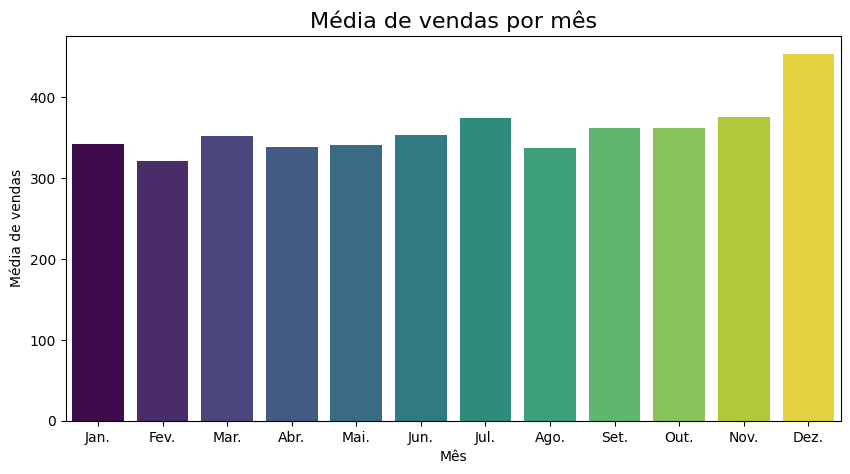

In [34]:
sales_by_month = sales.groupby('month')['sales'].mean().reset_index()

meses = ['Jan.', 'Fev.', 'Mar.', 'Abr.', 'Mai.', 'Jun.',
         'Jul.', 'Ago.', 'Set.', 'Out.', 'Nov.', 'Dez.']

plt.figure(figsize=(10,5))
sns.barplot(x='month', y='sales', data=sales_by_month, palette='viridis', hue='month')
plt.title('Média de vendas por mês', fontsize=16)
plt.xlabel('Mês')
plt.ylabel('Média de vendas')
plt.xticks(ticks=range(12), labels=meses)
plt.legend().remove()
plt.show()


No grafico acima podemos observar uma estabilidade entre janeiro e novembro, com pequenas oscilações mensais. No entanto, há um crescimento expressivo nas vendas no mês de dezembro. Esse padrão indica uma forte influência da sazonalidade, possivelmente associada a eventos promocionais e ao aumento natural do consumo no fim de ano. Portanto, é recomendável que estratégias de marketing e logística sejam intensificadas nesse período para aproveitar a alta demanda.

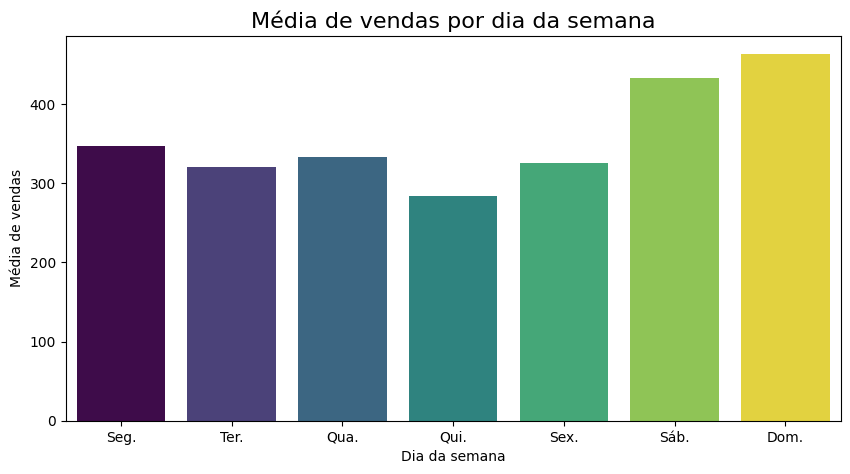

In [35]:
sales_by_weekday = sales.groupby('day_of_week')['sales'].mean().reset_index()

dias_semana = ['Seg.', 'Ter.', 'Qua.', 'Qui.', 'Sex.', 'Sáb.', 'Dom.']

plt.figure(figsize=(10,5))
sns.barplot(x='day_of_week', y='sales', data=sales_by_weekday, palette='viridis', hue='day_of_week')
plt.title('Média de vendas por dia da semana', fontsize=16)
plt.xlabel('Dia da semana')
plt.ylabel('Média de vendas')
plt.xticks(range(7), dias_semana)
plt.legend().remove()
plt.show()


Neste gráfico fica evidente que os fins de semana concentram os maiores volumes médios de vendas, com destaque para o domingo. Em contraste, os dias úteis apresentam um comportamento mais moderado, sendo a quinta-feira o dia com menor média de vendas. Essa diferença sugere que os consumidores tendem a concentrar suas compras nos fins de semana, o que deve ser considerado no planejamento operacional das lojas, como na alocação de estoque e equipes, para garantir um atendimento eficiente e satisfatório durante esses dias de maior movimento.

Em seguida, iremos analisar como é a distribuição das vendas por lojas e por grupo de lojas ('clueter').

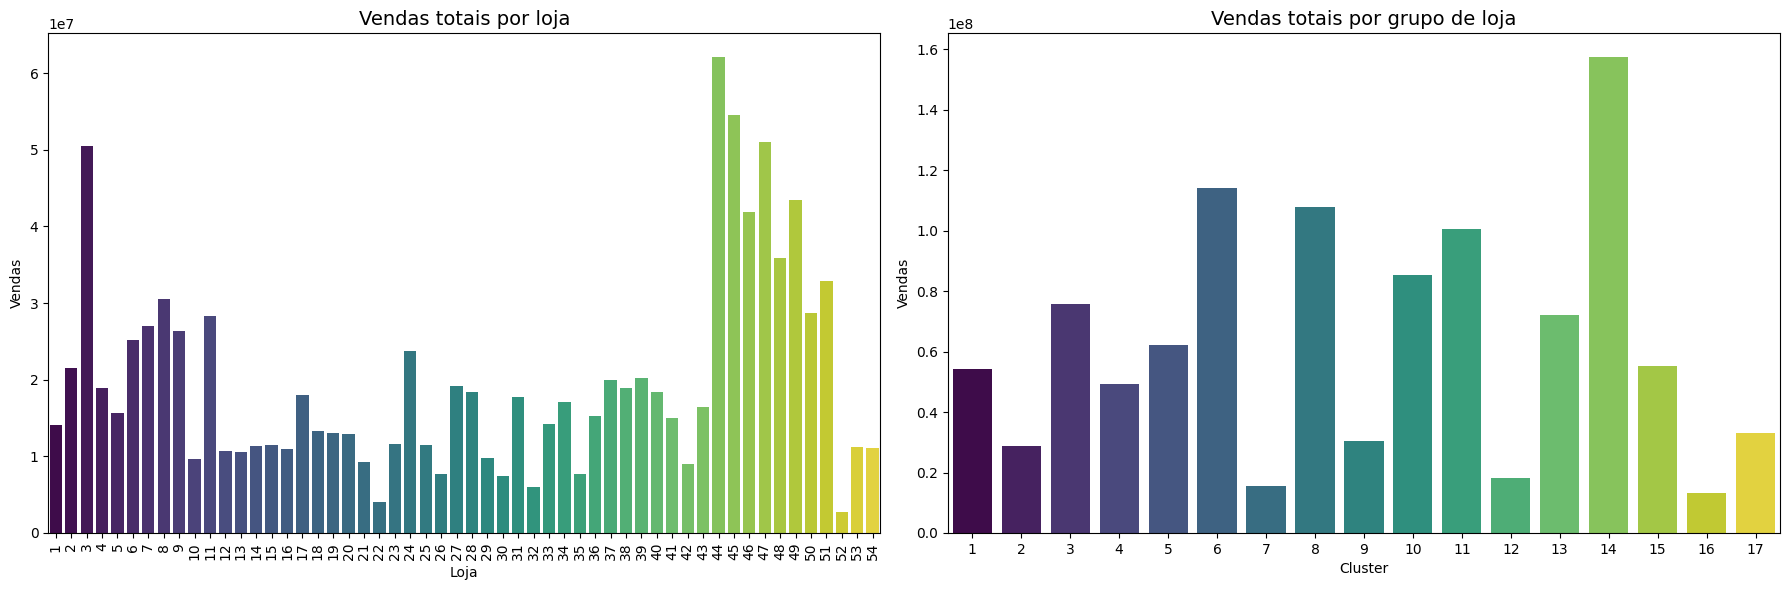

In [36]:
sales_by_store = sales.groupby('store_nbr')['sales'].sum().reset_index()

sales_by_cluster = sales.groupby('cluster')['sales'].sum().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.barplot(ax=axes[0], x='store_nbr', y='sales', data=sales_by_store, palette='viridis', hue='store_nbr', dodge=False)
axes[0].set_title('Vendas totais por loja', fontsize=14)
axes[0].set_xlabel('Loja')
axes[0].set_ylabel('Vendas')
axes[0].legend().remove()
axes[0].tick_params(axis='x', rotation=90)

sns.barplot(ax=axes[1], x='cluster', y='sales', data=sales_by_cluster, palette='viridis', hue='cluster', dodge=False)
axes[1].set_title('Vendas totais por grupo de loja', fontsize=14)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Vendas')
axes[1].legend().remove()

plt.tight_layout()
plt.show()


Os gráficos apresentados mostram que tanto as vendas por loja ('store_nbr') quanto por grupo de lojas ('cluster') apresentam variações significativas, indicando que essas variáveis carregam informações relevantes sobre o comportamento de vendas. No primeiro gráfico, observa-se que algumas lojas, como a loja 3, 44, 45 e 47 possuem volumes de vendas muito superiores às demais, sugerindo que características específicas de cada loja (como localização, tamanho ou perfil do público) influenciam diretamente no desempenho.

Já no segundo gráfico, a análise por cluster revela que certos grupos de lojas, como o cluster 14, concentram maiores volumes de vendas, o que reforça a utilidade dessa variável como uma forma de capturar padrões mais generalizados. Essas diferenças indicam que ambas as variáveis podem contribuir significativamente para o modelo XGBoost, que se beneficia de atributos com forte poder discriminatório e é capaz de capturar interações não lineares entre as features.

Por fim iremos observar como é a relação do preço do petróleo com o total de venda na rede de lojas. Como esta rede de lojas se localiza no Equador e este país é dependente do petróleo, espera-se que variações no preço do petróleo influenciem diretamente na economia do país e, consequentemente, no total de vendas.

Correlação entre o preço do petróleo e as vendas totais: -0.6901


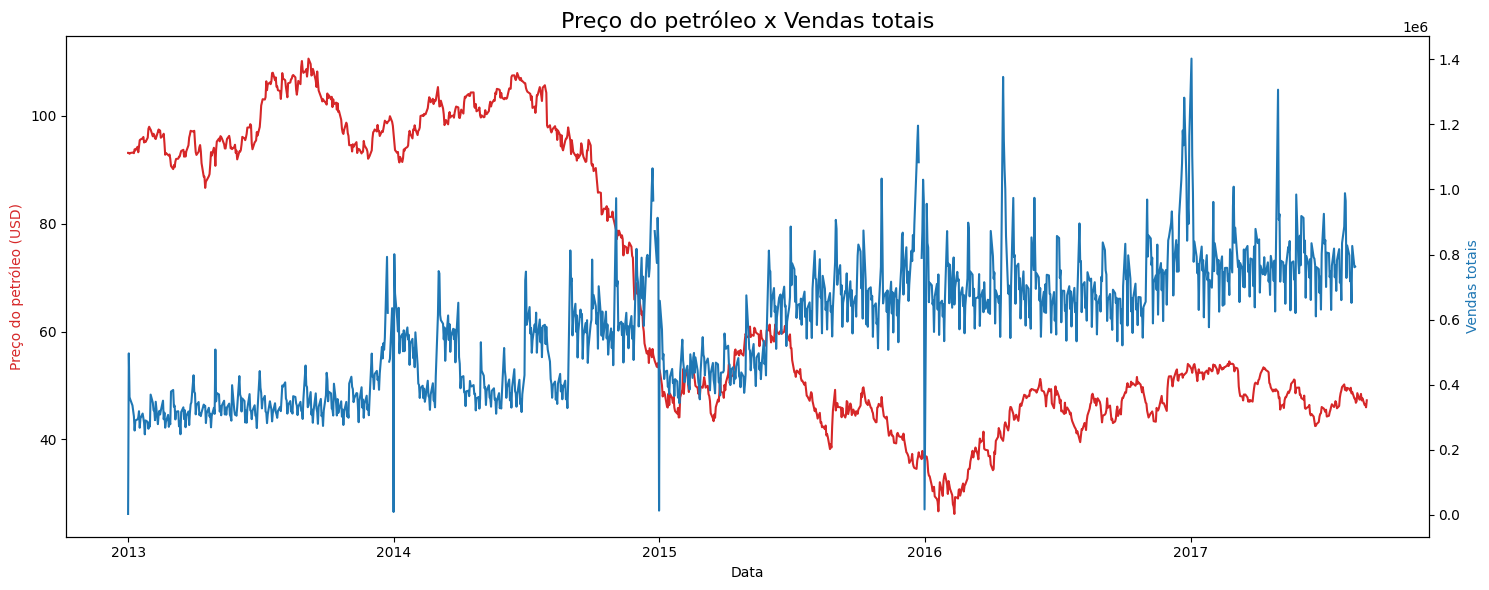

In [37]:
oil_sales = oil.merge(sales_by_date, on='date', how='left')

corr = oil_sales['dcoilwtico'].corr(oil_sales['sales'])

print(f'Correlação entre o preço do petróleo e as vendas totais: {corr:.4f}')


fig, ax1 = plt.subplots(figsize=(15,6))

ax1.plot(oil_sales['date'], oil_sales['dcoilwtico'], color='tab:red', label='Preço do petróleo')
ax1.set_xlabel('Data')
ax1.set_ylabel('Preço do petróleo (USD)', color='tab:red')

ax2 = ax1.twinx()
ax2.plot(oil_sales['date'], oil_sales['sales'], color='tab:blue', label='Vendas')
ax2.set_ylabel('Vendas totais', color='tab:blue')

plt.title('Preço do petróleo x Vendas totais', fontsize=16)
fig.tight_layout()
plt.show()


No gráfico acima podemos observar uma queda acentuada no preço do petróleo a partir de meados de 2014, enquanto as vendas totais mantêm uma tendência geral de crescimento, com oscilações sazonais. O coeficiente de correlação foi negativo, de -0,6901 entre as duas variáveis, sugerindo uma relação inversa moderada a forte, onde a queda do preço do petróleo tende a coincidir com o aumento das vendas.

# 🧮 4. Estruturação dos dados para modelagem

## 4.1 Análise da sazonalidade dos dados

Importando bibliotecas necessárias.

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

Inicialmente iremos explorar a decomposição sazonal da série de dados por meio dos gráficos de vendas ao longo do tempo, tendência, sazonalidade e resíduos.

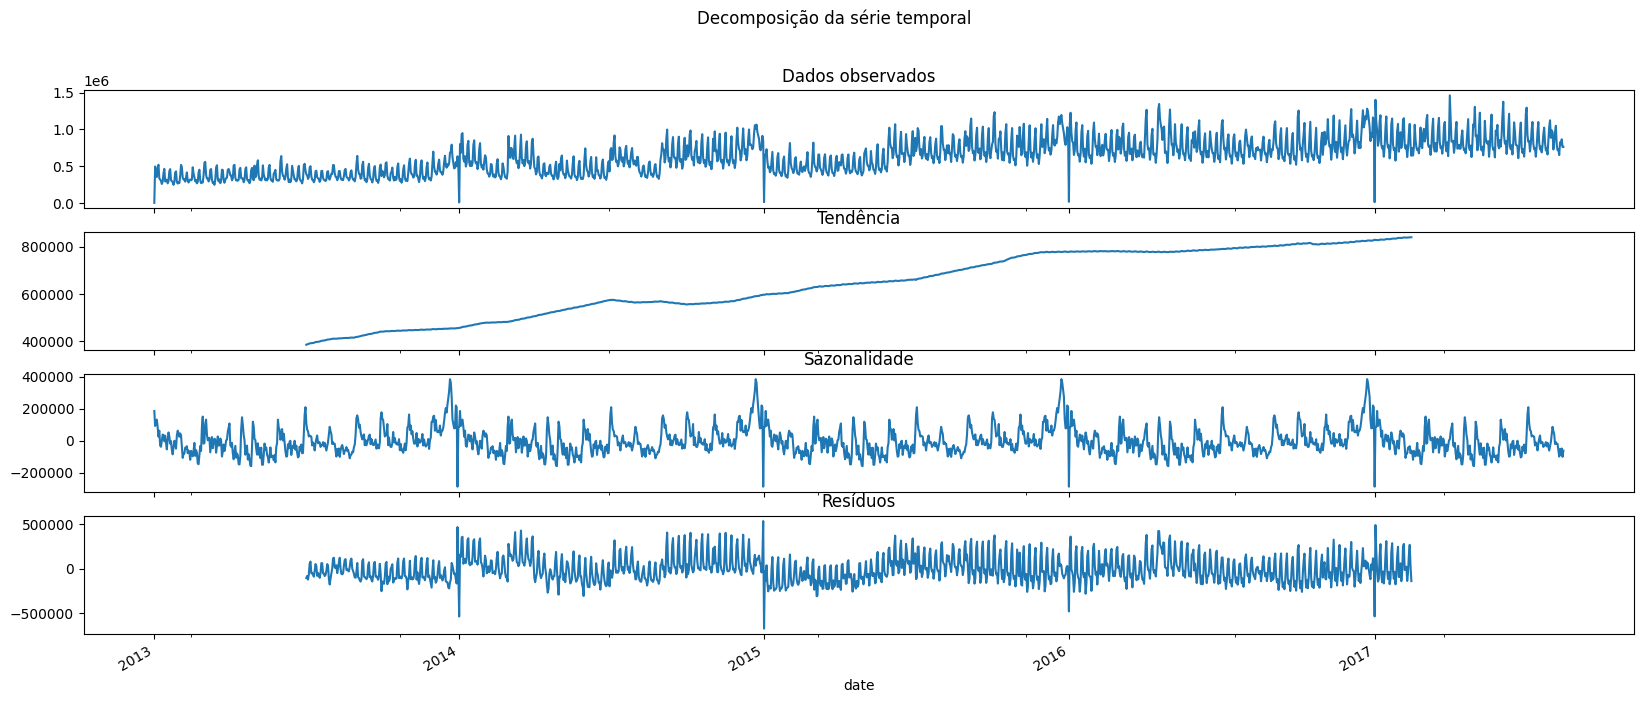

In [43]:
decomposicao = seasonal_decompose(sales_by_date.set_index('date')['sales'], period=365)

def plot_decomposicao(decomposicao, title):
    fig, axes = plt.subplots(4, 1, sharex=True, figsize=(20,8))
    decomposicao.observed.plot(ax=axes[0], title='Dados observados')
    decomposicao.trend.plot(ax=axes[1], title='Tendência')
    decomposicao.seasonal.plot(ax=axes[2], title='Sazonalidade')
    decomposicao.resid.plot(ax=axes[3], title='Resíduos')
    fig.suptitle(title)
    plt.show()

plot_decomposicao(decomposicao, 'Decomposição da série temporal')

A série original (dados observado) mostra variações regulares e picos recorrentes, com aumento gradual das vendas ao longo dos anos. A tendência revela um crescimento consistente no volume de vendas, especialmente após 2014. A sazonalidade indica padrões repetitivos, provavelmente associados a variações semanais ou mensais, enquanto os resíduos refletem oscilações não explicadas pelos componentes anteriores, com alguns desvios expressivos em determinados períodos. 

Abaixo iremos analisar os gráficos de autocorrelação e autocorrelação parcial da nossa série temporal.

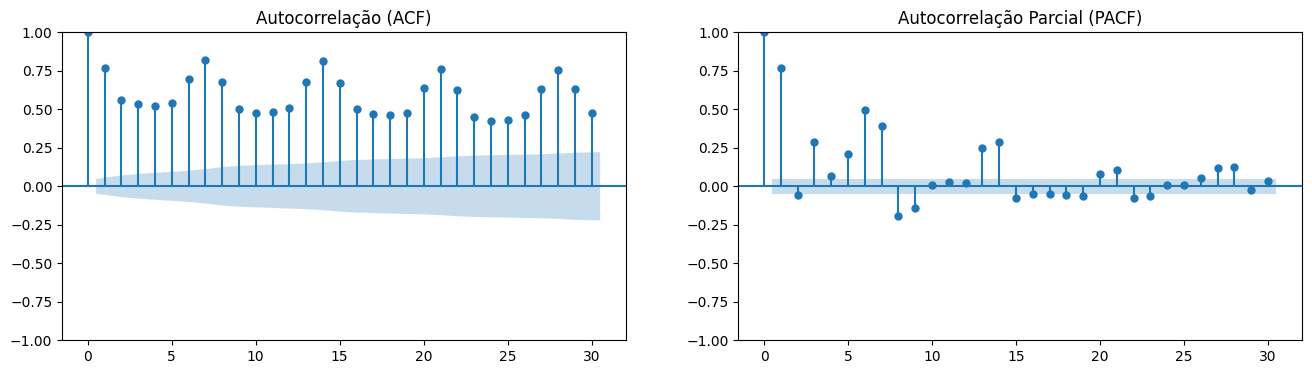

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(sales_by_date['sales'], lags=30, ax=ax[0], title='Autocorrelação (ACF)')
plot_pacf(sales_by_date['sales'], lags=30, ax=ax[1], title='Autocorrelação Parcial (PACF)')
plt.show()


Os gráficos de ACF e PACF indicam que a série não é estacionária, pois a ACF decai lentamente. Por isso, recomenda-se d = 1. Há evidências de sazonalidade semanal (s = 7), com picos na ACF e PACF a cada 7 lags, sugerindo diferenciação sazonal (D = 1) e a inclusão de termos sazonais autoregressivos e de média móvel (P = 1, Q = 1). A PACF mostra corte após o lag 1 ou 2, o que sugere p = 1 ou 2, e a ACF apresenta picos nos primeiros lags, indicando q = 1 ou 2.

Por fim, iremos realizar o teste de Dickey-Fuller Aumentado para saber se a série é estacionária ou não.

In [46]:
result = adfuller(sales_by_date['sales'])
print(f'ADF Statistic: {result[0]:.5f}')
print(f'p-value: {result[1]:.5f}')

if result[1] < 0.05:
    print('A série é estacionária.')
else:
    print('A série NÃO é estacionária.')

ADF Statistic: -2.61620
p-value: 0.08970
A série NÃO é estacionária.


## 4.2 Bases de treino e teste para o SARIMA

O modelo SARIMA, que é o modelo padrão utilizado pela empresa, considera apenas a data como variável independente. Como este modelo não aceita datas repetidas, iremos criar um novo df agrupado pela data, que deverá ser o índice, e com a soma dos valores de 'sales'.

In [47]:
df_sarima = sales.groupby('date')['sales'].sum().reset_index()
df_sarima.set_index(['date'], inplace=True, drop=True)
df_sarima.head()

,sales
date,
2013-01-01,2511.618999
2013-01-02,496092.417944
2013-01-03,361461.231124
2013-01-04,354459.677093
2013-01-05,477350.121229


Para dividir o conjunto de treino e teste, precisamos definir a data limite que irá separar ambos os conjuntos (cutoff). Neste projeto, deixaremos 90% dos dados para treino e 10% para teste.

In [48]:
cutoff = int(len(df_sarima)*0.9)

train_sarima = df_sarima[:cutoff].asfreq('D')
test_sarima = df_sarima[cutoff:].asfreq('D')

In [49]:
train_sarima.head()

,sales
date,
2013-01-01,2511.618999
2013-01-02,496092.417944
2013-01-03,361461.231124
2013-01-04,354459.677093
2013-01-05,477350.121229


In [50]:
test_sarima.head()

,sales
date,
2017-02-28,9.493668e+05
2017-03-01,1.008522e+06
2017-03-02,8.362252e+05
2017-03-03,8.826398e+05
2017-03-04,1.125736e+06


Para que os conjuntos de treino e teste tivessem frequência diária, foi utilizado o método .asfreq('D') do pandas. Entretanto, podem surgir datas com valores vazios. Por isso precisaremos verificar a existência de valores nulos.

In [51]:
print(f'Valores nulos em train_sarima: {train_sarima['sales'].isna().sum()}')

Valores nulos em train_sarima: 4


Como verificamos acima, 4 datas não possuem valores de vendas. Para manter a frequência diária do conjunto de treino precisamos preencher esses dados. Para isso vamos usar o método interpolate.

In [52]:
train_sarima = train_sarima.interpolate()

In [53]:
print(f'Valores nulos em train_sarima: {train_sarima['sales'].isna().sum()}')

Valores nulos em train_sarima: 0


In [54]:
print(f'Valores nulos em test_sarima: {test_sarima['sales'].isna().sum()}')

Valores nulos em test_sarima: 0


O conjunto de teste não possui valores nulos, então não será preciso aplicar o método interpolate.

## 4.3 Bases de treino e teste para o PROPHET

Semelhante ao SARIMA, o modelo Prophet só utiliza a data como variável independente no modelo, entretanto, ela não precisa ser definida como índice do df. Além disso, o modelo requer que as colunas de data e valores sejam renomeadas como 'ds' e 'y', respectivamente. 

In [55]:
df_prophet = sales.groupby('date')['sales'].sum().reset_index()
train_prophet = df_prophet[:cutoff].reset_index(drop=True)
train_prophet.columns = ['ds', 'y']
test_prophet = df_prophet[cutoff:].reset_index(drop=True)
test_prophet.columns = ['ds', 'y']

In [56]:
train_prophet.head()

,ds,y
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-05,477350.121229


In [57]:
test_prophet.head()

,ds,y
0,2017-02-28,9.493668e+05
1,2017-03-01,1.008522e+06
2,2017-03-02,8.362252e+05
3,2017-03-03,8.826398e+05
4,2017-03-04,1.125736e+06


## 4.4 Bases de treino e teste para o XGBoost

Diferentemente do SARIMA e do Prophet, que foram projetados para trabalhar diretamente com séries temporais, o XGBoost não possui entendimento nativo de tempo, sendo um modelo supervisionado que usa várias features para prever a variável alvo ('sales'). Portanto, a base de dados de treino e teste do XGBoost será diferente da usada para o SARIMA e Prophet, sem a variável 'date' e contendo as variáveis temporais 'day', 'day_of_week', 'month' e 'year', além de 'is_holiday', 'store_nbr', 'cluster', 'family', 'onpromotion' e 'dcoilwtico'.

Além disso, os dados não serão agrupados por data, pois esse modelo permite que a mesma data tenha diferentes valores de 'sale'. Desta forma, ao final do processo de modelagem, será necessário agregar esses resultados por data para que seja feita a comparação com os resultados do SARIMA e Prophet.

Para construir o df usado para o XGBoost iremos usar o df sales, mas inicialmente iremos remover a coluna 'id', que não influencia nos resultados, e 'is_weekend', pois é redundante com 'day_of_week'.

Ao invés de fazer um drop em 'id' e 'is_weekend', iremos filtrar apenas as colunas que iremos utilizar já deixando-as em uma ordem mais organizada.

In [58]:
df_xgb = sales[['date',
                'day',
                'day_of_week',
                'month',
                'year',
                'is_holiday',
                'store_nbr',
                'cluster',
                'family',
                'onpromotion',                                       
                'dcoilwtico',
                'sales']].copy()
df_xgb.columns

Index(['date', 'day', 'day_of_week', 'month', 'year', 'is_holiday',
       'store_nbr', 'cluster', 'family', 'onpromotion', 'dcoilwtico', 'sales'],
      dtype='object')

Como a base de dados que iremos utilizar na modelagem com o XGBoost possui variáveis categóricas, precisamos identificar o tipo dessas variáveis e fazer o tratamento adequado.

In [59]:
df_xgb.dtypes

date           datetime64[ns]
day                     int32
day_of_week             int32
month                   int32
year                    int32
is_holiday               bool
store_nbr               int64
cluster                 int64
family                 object
onpromotion             int64
dcoilwtico            float64
sales                 float64
dtype: object

Podemos ver que as colunas 'day_of_week', 'store_nbr', 'cluster' estão como 'int' e a coluna 'family' está como object. Como essas colunas representam categorias, vamos convertê-las para o tipo 'category'.

In [60]:
colunas_category = ['day_of_week', 'store_nbr', 'cluster', 'family']
df_xgb[colunas_category] = df_xgb[colunas_category].astype('category')
df_xgb.dtypes

date           datetime64[ns]
day                     int32
day_of_week          category
month                   int32
year                    int32
is_holiday               bool
store_nbr            category
cluster              category
family               category
onpromotion             int64
dcoilwtico            float64
sales                 float64
dtype: object

Como esse conjunto de dados é estruturalmente diferente dos conjuntos usados no SARIMA e Prophet, a forma como iremos dividir os conjuntos de treino e teste também é diferente. Para tanto iremos utilizar a cutoff_date sendo igual primeiro dia do conjunto de teste dos outros modelos (28/02/2017).

In [61]:
# Separar treino e teste para XGBoost
cutoff_date = pd.to_datetime('2017-02-28')

train_xgb = df_xgb[df_xgb['date'] < cutoff_date].copy().reset_index(drop=True)
test_xgb = df_xgb[df_xgb['date'] >= cutoff_date].copy().reset_index(drop=True)

In [62]:
train_xgb.head()

,date,day,day_of_week,month,year,is_holiday,store_nbr,cluster,family,onpromotion,dcoilwtico,sales
0,2013-01-01,1,1,1,2013,True,1,13,AUTOMOTIVE,0,93.14,0.0
1,2013-01-01,1,1,1,2013,True,1,13,BABY CARE,0,93.14,0.0
2,2013-01-01,1,1,1,2013,True,1,13,BEAUTY,0,93.14,0.0
3,2013-01-01,1,1,1,2013,True,1,13,BEVERAGES,0,93.14,0.0
4,2013-01-01,1,1,1,2013,True,1,13,BOOKS,0,93.14,0.0


In [63]:
test_xgb.head()

,date,day,day_of_week,month,year,is_holiday,store_nbr,cluster,family,onpromotion,dcoilwtico,sales
0,2017-02-28,28,1,2,2017,True,1,13,AUTOMOTIVE,0,54.0,2.0
1,2017-02-28,28,1,2,2017,True,1,13,BABY CARE,0,54.0,0.0
2,2017-02-28,28,1,2,2017,True,1,13,BEAUTY,1,54.0,2.0
3,2017-02-28,28,1,2,2017,True,1,13,BEVERAGES,11,54.0,1059.0
4,2017-02-28,28,1,2,2017,True,1,13,BOOKS,0,54.0,0.0


Por fim, iremos dividir as variáveis indepedentes (X) e a variável dependente (y) em conjuntos de dados diferentes para o treino e teste.

In [64]:
X_train_xgb = train_xgb.drop(['date','sales'], axis=1)
y_train_xgb = train_xgb['sales']

X_test_xgb = test_xgb.drop(['date','sales'], axis=1)
y_test_xgb = test_xgb['sales']

# 💻 5. Modelagem

## 5.1 Criando a função para diagnóstico dos modelos

A função abaixo irá calculas as métricas de avaliação dos modelos, bem como os gráficos para análise dos resultados.

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, root_mean_squared_log_error
from scipy.stats import pearsonr

def diagnostico_modelo(y_true, y_pred):
    # Converte para arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Métricas
    corr, _ = pearsonr(y_true, y_pred)
    vies = np.mean(y_pred - y_true)
    vies_perc = vies / np.mean(y_true) * 100
    rmse = root_mean_squared_error(y_true, y_pred)
    rmse_perc = rmse / np.mean(y_true) * 100
    rmsle = root_mean_squared_log_error(y_true, y_pred)

    # Impressão das métricas
    print('\nMétricas do modelo:\n')
    print(f'Correlação: {corr:.4f}')
    print(f'Viés: {vies:,.2f}')
    print(f'Viés (%): {vies_perc:.2f}%')
    print(f'RMSE: {rmse:,.2f}')
    print(f'RMSE (%): {rmse_perc:.2f}%')
    print(f'RMSLE: {rmsle:.5f}')

    # Erro
    erro = (y_pred - y_true) / y_true.mean() * 100

    # Cria o grid 2x2
    fig = plt.figure(figsize=(10, 8))
    gs = fig.add_gridspec(2, 2)
    
    # Gráfico 1: Série temporal
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(y_true, label='Real', color='black', linewidth=2, alpha=0.7)
    ax1.plot(y_pred, label='Estimado', color='red')
    ax1.set_title('Valores reais x estimados ao longo do tempo')
    ax1.set_xlabel('Tempo')
    ax1.set_ylabel('Vendas')
    ax1.legend()
    ax1.grid(True)

    # Gráfico 2: Real x Estimado
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.scatter(y_true, y_pred, alpha=0.6, color='purple')
    max_val = max(np.max(y_true), np.max(y_pred))
    ax2.plot([0, max_val], [0, max_val], '--', color='gray')
    ax2.set_title('Valor real x estimado')
    ax2.set_xlabel('Real')
    ax2.set_ylabel('Estimado')
    ax2.grid(True)

    # Gráfico 3: Erro x Real
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.scatter(y_pred, erro, alpha=0.6, color='darkred')
    ax3.axhline(0, color='black', linestyle='--')
    ax3.set_title('Erro em função do valor real')
    ax3.set_xlabel('Real')
    ax3.set_ylabel('Erro (%)')
    ax3.grid(True)

    plt.tight_layout()
    plt.show()


## 5.2 Modelagem com SARIMA

Importando a biblioteca de ajuste do SARIMA.

In [67]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Iremos ajustar o modelo SARIMA com parâmetros conforme discutido no tópico 4.1, sendo:
* p = 2
* d = 1
* q = 2

* P = 1
* D = 1
* Q = 1
* s = 7

Além disso, como verificamos que a série é do tipo não estacionária, iremos utilizar o parâmetro enforce_stationarity=False.

In [68]:
modelo_sarima = SARIMAX(train_sarima['sales'],
                order=(2,1,2),
                seasonal_order=(1,1,1,7),
                enforce_stationarity=False
                ).fit()

Uma vez ajustado o modelo, iremos realizar a previsão para o conjunto de teste e criar um DataFrame com os resultados (df_pred_sarima).

In [69]:
pred_sarima = modelo_sarima.predict(len(train_sarima), len(train_sarima) + len(test_sarima)-1, dynamic=False)
df_pred_sarima = pd.DataFrame()
df_pred_sarima['ds'] = test_sarima.index
df_pred_sarima['y'] = test_sarima.values
df_pred_sarima['yhat'] = pred_sarima.values


df_pred_sarima

,ds,y,yhat
0,2017-02-28,9.493668e+05,692830.963756
1,2017-03-01,1.008522e+06,745403.717659
2,2017-03-02,8.362252e+05,628308.218141
3,2017-03-03,8.826398e+05,753327.428544
4,2017-03-04,1.125736e+06,962381.925257
...,...,...,...
164,2017-08-11,8.263737e+05,747314.579876
165,2017-08-12,7.926305e+05,953165.216816
166,2017-08-13,8.656397e+05,976615.606957
167,2017-08-14,7.609224e+05,765236.819770



Métricas do modelo:

Correlação: 0.8350
Viés: -63,031.42
Viés (%): -7.32%
RMSE: 113,909.34
RMSE (%): 13.22%
RMSLE: 0.11937


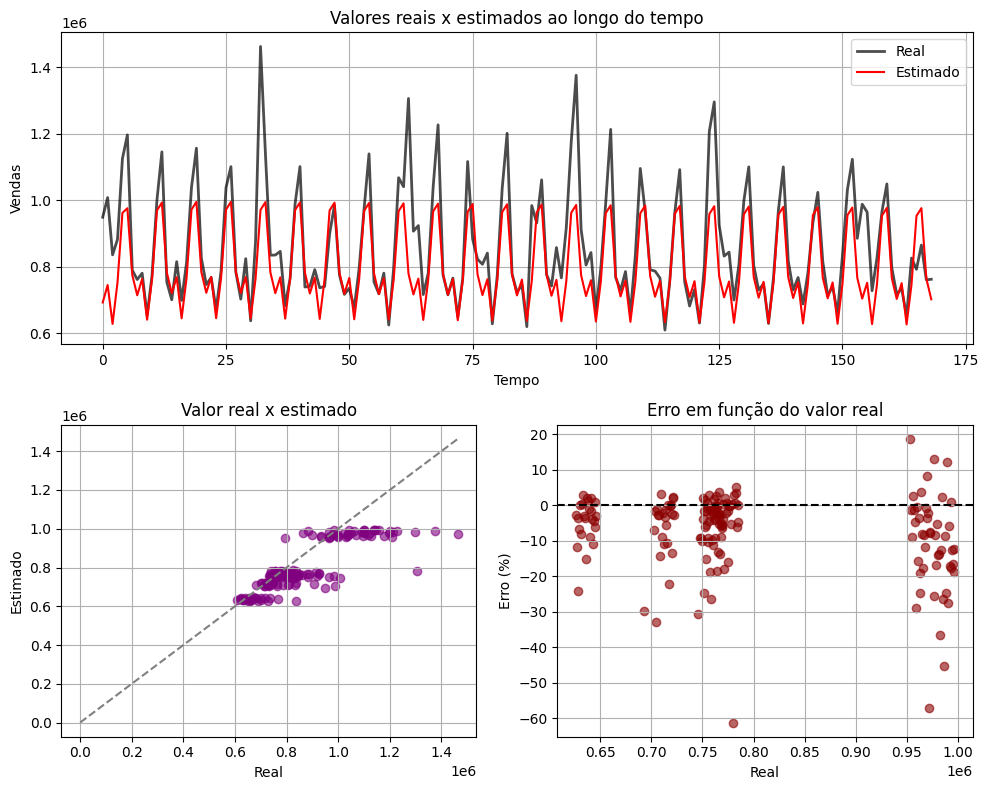

In [70]:
diagnostico_modelo(df_pred_sarima['y'], df_pred_sarima['yhat'])

O modelo SARIMA apresentou desempenho razoável, com correlação de 0,8350 indicando boa relação entre valores reais e estimados, embora com viés negativo de -7,32%, sugerindo tendência de subestimar as vendas.

O gráfico superior mostra que as estimativas captam bem o padrão sazonal, mas subestimam picos de vendas. O gráfico de dispersão (inferior esquerdo) confirma essa limitação, com saturação dos valores estimados em torno de 1 milhão, enquanto os reais ultrapassam esse valor. O gráfico de erro percentual (inferior direito) destaca maior subestimação em volumes de venda mais altos. O RMSE de 13,22% e o RMSLE de 0,119 indicam erro médio relativamente controlado, mas com margem para melhorias em picos de demanda.

## 5.3 Modelagem com Prophet

Importando bibliotecas do Prophet.

In [71]:
from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.plot import plot_components_plotly

### 5.3.1 Ajuste do modelo Prophet padrão

Iremos treinar o modelo_prophet e realizar a previsão para 169 dias no futuro, o que corresponde com o tamanho do conjunto de teste.

In [72]:
modelo_prophet = Prophet()
modelo_prophet.fit(train_prophet)

futuro = modelo_prophet.make_future_dataframe(periods=169, freq='D')

previsao = modelo_prophet.predict(futuro)

11:39:40 - cmdstanpy - INFO - Chain [1] start processing
11:39:40 - cmdstanpy - INFO - Chain [1] done processing


No gráfico abaixo podemos ver como o modelo captou as variações de tendência e sazonalidade nos meses do ano e dos dias na semana.

In [73]:
plot_components_plotly(modelo_prophet, previsao)

Vamos criar o df com os resultados do modelo Prophet e aplicar a função de diagnóstico do modelo.

In [75]:
df_previsao = previsao[['ds', 'yhat']]
df_pred_prophet = pd.merge(test_prophet, df_previsao, on='ds', how='inner')
df_pred_prophet

,ds,y,yhat
0,2017-02-28,9.493668e+05,746002.479288
1,2017-03-01,1.008522e+06,774002.876919
2,2017-03-02,8.362252e+05,696818.879663
3,2017-03-03,8.826398e+05,770030.488371
4,2017-03-04,1.125736e+06,962338.022724
...,...,...,...
164,2017-08-11,8.263737e+05,718971.709490
165,2017-08-12,7.926305e+05,906225.526130
166,2017-08-13,8.656397e+05,958876.472413
167,2017-08-14,7.609224e+05,758873.550484



Métricas do modelo:

Correlação: 0.8135
Viés: -46,887.25
Viés (%): -5.44%
RMSE: 112,724.17
RMSE (%): 13.09%
RMSLE: 0.11683


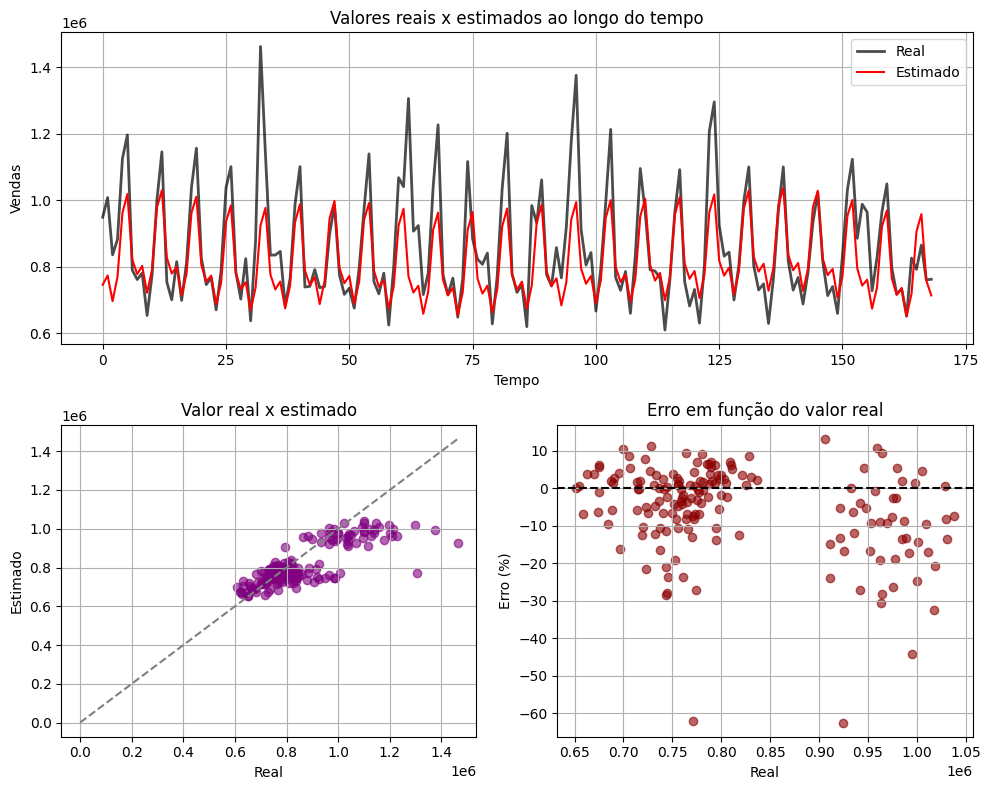

In [76]:
diagnostico_modelo(df_pred_prophet['y'], df_pred_prophet['yhat'])

O diagnóstico da modelagem com Prophet apresenta métricas ligeiramente melhores que o SARIMA, com menores valores de RMSE, RMSLE e viés, o que indica estimativas menos subestimadas. Contudo, o SARIMA teve correlação ligeiramente superior, sugerindo que acompanha melhor a variabilidade dos dados. Visualmente, ambos os modelos subestimam os picos de venda, mas o Prophet parece suavizar menos os ciclos em algumas regiões. 

Os gráficos do modelo Prophet mostram que, apesar de acompanhar o padrão geral das séries, o modelo tende a suavizar as variações e subestimar os picos de vendas, especialmente em períodos de maior volume. O gráfico de dispersão “Valor real x estimado” indica uma concentração dos pontos abaixo da linha ideal, reforçando a tendência de subestimação. Além disso, também podemos ver uma saturação do valor estimado próximo a 1 milhão, assim como no SARIMA. Já o gráfico de erro percentual revela maior variabilidade dos erros em valores elevados, com predomínio de erros negativos, sugerindo que o modelo tem dificuldade em capturar adequadamente os maiores picos de vendas.

No geral, embora o SARIMA e o Prophet tenham desempenho semelhante, o Prophet leva uma ligerira vantagem.

### 5.3.2 Ajuste do modelo Prophet com o componente 'feriados'

Para incluir a variável relativa aos feriados no modelo, precisamos criar um df que tenha apenas as datas do feriado e a sua descrição com colunas nomeadas como 'ds' e 'holiday'.

In [83]:
feriados = holidays_nacionais.copy()

feriados_prophet = feriados.rename(columns={'date': 'ds', 'description': 'holiday'})[['ds', 'holiday']]
feriados_prophet['ds'] = pd.to_datetime(feriados_prophet['ds'])

In [84]:
feriados_prophet.head()

,ds,holiday
14,2012-08-10,Primer Grito de Independencia
20,2012-10-12,Traslado Independencia de Guayaquil
21,2012-11-02,Dia de Difuntos
22,2012-11-03,Independencia de Cuenca
31,2012-12-21,Navidad-4


Ajuste do modelo Prophet com a variável feriados.

In [79]:
modelo_prophet_feriado = Prophet(holidays=feriados_prophet)
modelo_prophet_feriado.fit(train_prophet)

futuro = modelo_prophet_feriado.make_future_dataframe(periods=169, freq='D')

previsao_feriado = modelo_prophet_feriado.predict(futuro)

11:40:50 - cmdstanpy - INFO - Chain [1] start processing
11:40:50 - cmdstanpy - INFO - Chain [1] done processing


No gráfico abaixo podemos ver como o modelo captou as variações de tendência e sazonalidade nos meses do ano e dos dias na semana. Podemos perceber que os gráficos são muito semelhantes aos gerados pelo modelo sem a variável feriados.

In [82]:
plot_components_plotly(modelo_prophet_feriado, previsao)

Vamos criar o df com os resultados do modelo Prophet com feriados e aplicar a função de diagnóstico do modelo.

In [80]:
df_pred_feriado = previsao_feriado[['ds', 'yhat']]

df_pred_prophet_feriado = pd.merge(df_pred_feriado, test_prophet, on='ds', how='inner')
df_pred_prophet_feriado.head()

,ds,yhat,y
0,2017-02-28,775802.385726,9.493668e+05
1,2017-03-01,759029.212388,1.008522e+06
2,2017-03-02,681455.765562,8.362252e+05
3,2017-03-03,751540.081871,8.826398e+05
4,2017-03-04,943222.447467,1.125736e+06



Métricas do modelo:

Correlação: 0.8421
Viés: -68,591.48
Viés (%): -7.96%
RMSE: 118,405.73
RMSE (%): 13.74%
RMSLE: 0.12521


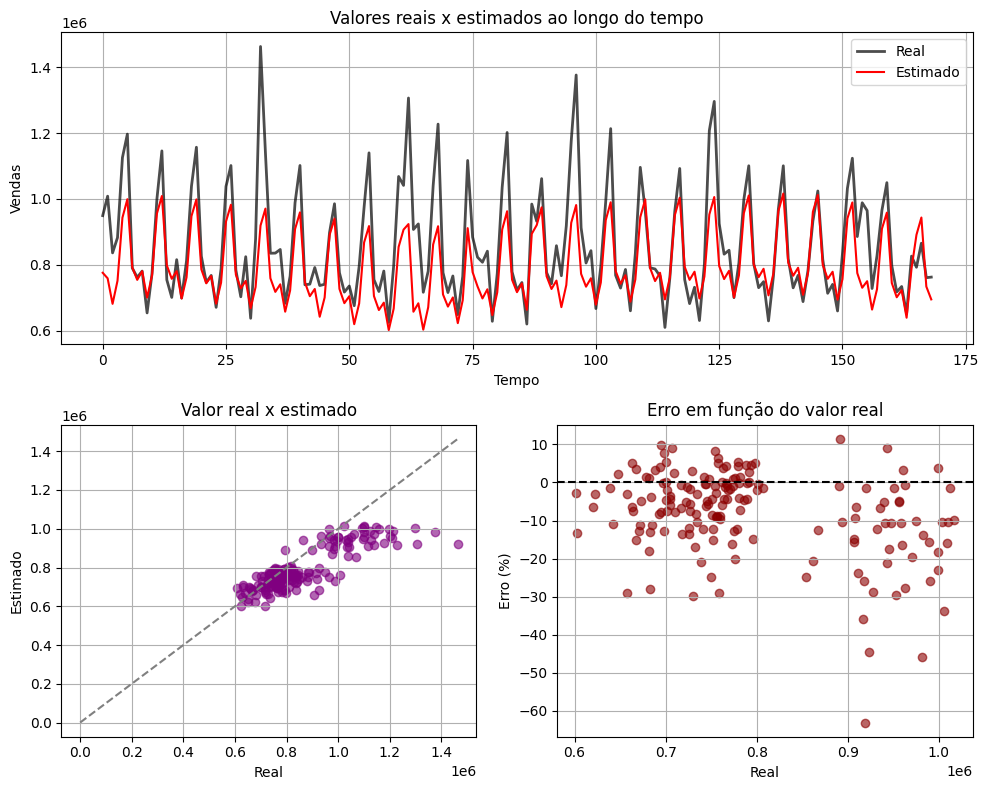

In [81]:
diagnostico_modelo(df_pred_prophet_feriado['y'], df_pred_prophet_feriado['yhat'])

Os gráficos do modelo Prophet com feriados mostram que o padrão de subestimação persiste, especialmente nos picos, embora haja uma leve melhora na aderência da série estimada à série real em algumas regiões. O gráfico de dispersão continua indicando uma concentração de pontos abaixo da linha ideal, com saturação dos valores próximos a 1 milhão, e o gráfico de erro percentual mostra erros ainda mais negativos em valores mais altos, com uma dispersão levemente ampliada.

Ao comparar os resultados da modelagem sem e com feriados, podemos notar que a correlação aumentou de 0.8135 para 0.8421, indicando melhor alinhamento entre os valores previstos e reais. No entanto, o viés piorou, passando de -46.9 mil (-5.44%) para -68.6 mil (-7.96%), ou seja, o modelo passou a subestimar ainda mais. O RMSE também aumentou ligeiramente, de 112.7 mil (13.09%) para 118.4 mil (13.74%), o que indica maior erro médio absoluto. Com essa mesma tendência, o RMSLE também subiu de 0.11683 para 0.12521, reforçando que a melhora na correlação não se traduziu em previsões proporcionalmente mais precisas.

Essa situação mostra que, embora a inclusão dos feriados possa ajudar a capturar padrões adicionais (aumentando a correlação), ela também pode introduzir ruídos ou complexidade desnecessária, que pioram a precisão geral das previsões. Isso sugere que a variável de feriado, nesse caso, não contribuiu positivamente para a redução do erro do modelo.

Para comparações futuras iremos apresentar apenas os resultados do modelo Prophet sem a inclusão dos feriados.

## 5.4 Modelagem com XGBoost

Importando as bibliotecas usadas na modelagem com o XGBoost.

In [85]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

Antes de iniciar a modelagem, precisamos otimizar a escolha dos parâmetros do modelo.

Para isso vamos usar as classes GridSearchCv e TimeSeriesSplit da biblioteca sklearn.model_selection. A GridSearchCV faz uma busca exaustiva para encontrar os melhores parâmetros em um grid prédefinido, quanto a TimeSeriesSplit divide a série temporal em um número definido de subconjuntos (k-folds) para a validação cruzada.

In [100]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 20],
    'learning_rate': [0.1, 0.3, 0.5],
    'colsample_bytree': [0.8, 1.0]
}

cv = TimeSeriesSplit(n_splits=5)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', enable_categorical=True)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=cv,
    verbose=3
)

grid_search.fit(X_train_xgb, y_train_xgb)

print('Melhores parâmetros encontrados:', grid_search.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=50;, score=0.777 total time=   0.6s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=50;, score=0.779 total time=   1.2s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=50;, score=0.852 total time=   2.2s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=50;, score=0.800 total time=   2.6s
[CV 5/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=50;, score=0.889 total time=   3.2s
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.783 total time=   0.9s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.784 total time=   2.0s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.853 total time=   2.8s
[CV 4/5

Uma vez definidos os melhores parâmetros, iremos treinar o modelo XGBoost.

In [89]:
modelo_xgb = xgb.XGBRegressor(
    objective='reg:squarederror', enable_categorical=True, 
    colsample_bytree = 0.8, learning_rate=0.1, max_depth=5, n_estimators=150
    )

modelo_xgb.fit(X_train_xgb,y_train_xgb)

preds = modelo_xgb.predict(X_test_xgb)

Uma vez feita a predição para o conjunto de teste, vamos criar um df com as datas, valores reais e previstos.

In [90]:
pred_xgb = test_xgb[['date', 'sales']].copy()
pred_xgb['pred'] = preds
pred_xgb.head()

,date,sales,pred
0,2017-02-28,2.0,7.083441
1,2017-02-28,0.0,4.289784
2,2017-02-28,2.0,-15.103902
3,2017-02-28,1059.0,1980.653809
4,2017-02-28,0.0,4.289784


Como podemos ver acima, quando os valores são muito próximos de zero, o modelo pode estimar valores negativos. Para que os resultados sejam coerentes, iremos substituir valores negativos por zero.

In [91]:
pred_xgb['pred'] = pred_xgb['pred'].clip(lower=0)

Agora iremos agrupar os dados por data, somar os valores reais e estimados de venda e aplicar a função de diagnóstico.

In [93]:
df_pred_xgb = pred_xgb.groupby('date')[['sales', 'pred']].sum().reset_index()
df_pred_xgb.columns = ['ds', 'y', 'yhat']
df_pred_xgb.head()

,ds,y,yhat
0,2017-02-28,9.493668e+05,7.304697e+05
1,2017-03-01,1.008522e+06,9.373882e+05
2,2017-03-02,8.362252e+05,7.844367e+05
3,2017-03-03,8.826398e+05,8.949697e+05
4,2017-03-04,1.125736e+06,1.095338e+06



Métricas do modelo:

Correlação: 0.9037
Viés: -26,763.46
Viés (%): -3.11%
RMSE: 76,828.65
RMSE (%): 8.92%
RMSLE: 0.08131


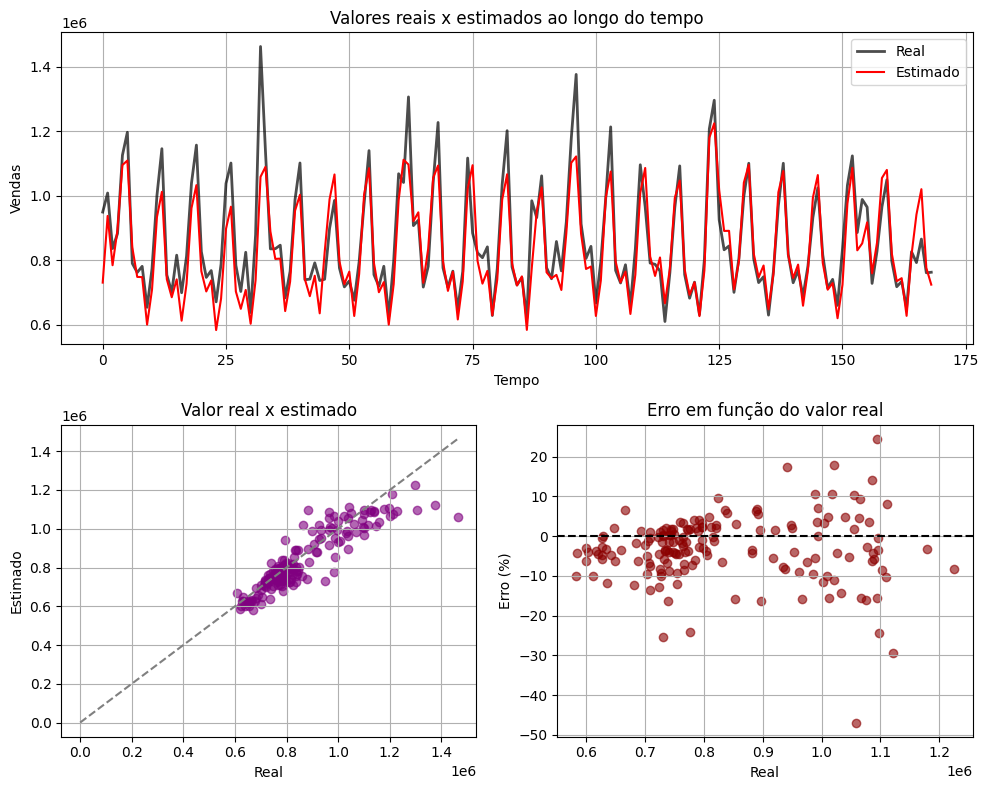

In [94]:
diagnostico_modelo(df_pred_xgb['y'], df_pred_xgb['yhat'])

Ao analisar as métricas, vemos que o XGBoost alcançou uma correlação de 0.9037, o maior valor entre os modelos testados, indicando forte aderência entre os valores reais e os estimados. O viés também foi o menor entre os modelos, mostrando que o XGBoost teve baixa tendência sistemática de erro. Da mesma forma, o RMSE e RMSLE foram os menores encontrados, indicando maior precisão também em termos relativos.

No gráfico dos valores reais e estimados ao longo do tempo, vemos que a linha vermelha, representando as previsões do modelo, acompanha de maneira fiel a variação da linha preta (valores reais), inclusive nos picos e vales sazonais, o que os modelos SARIMA e Prophet não conseguiram reproduzir com a mesma fidelidade. O gráfico de dispersão entre valores reais e estimados mostra uma boa concentração dos pontos em torno da linha de identidade, sem a saturação em valores próximos a 1 milhão como os demais modelos. O gráfico de erro percentual apresenta menor dispersão, com a maioria dos pontos próximos de zero.

Abaixo iremos analisar quais variáveis foram mais importantes para a modelagem com o XGBoost.

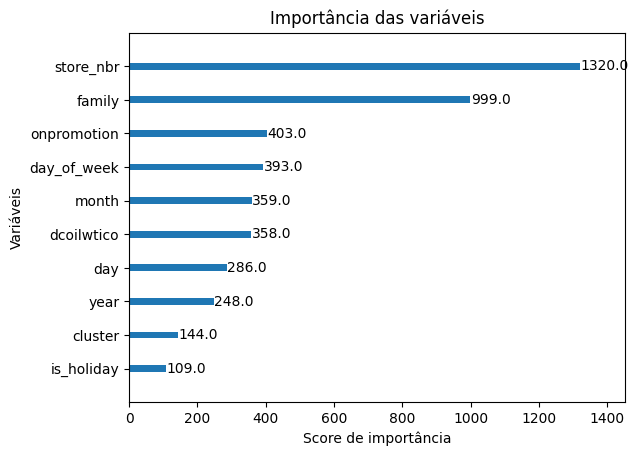

In [97]:
xgb.plot_importance(modelo_xgb)
plt.title('Importância das variáveis')
plt.xlabel('Score de importância')
plt.ylabel('Variáveis')
plt.grid(False)
plt.show()

Conforme o gráfico acima, o modelo XGBoost está atribuindo maior importância à variável 'store_nbr', seguida por 'family' e 'onpromotion'. Isso significa que o modelo está identificando padrões específicos por loja e está usando fortemente essa informação para prever as vendas. Entre as variáveis temporais, podemos ver que as primeiras que aparecem são 'day_of_week' seguida de 'month', o que reforça a sazonalidade nos dias da semana e dos meses no ano. Podemos ver também que o preço do petróleo foi uma variável importante para a previsão das vendas, confirmando a sua influência na economia e padrões de compra.

# 📈 6. Resumo dos resultados e discussão

Na tabela abaixo estão as estatísticas do teste para os três modelos avaliados.

<div align=center>

| Métrica       | SARIMA   | Prophet |   XGBoost  |
|---------------|----------|---------|------------|
| Correlação    | 0.8350   | 0.8135  | **0.9037** |
| Viés (%)      | -7.32%   | -5.44%  | **-3.11%** |
| RMSE (%)      | 13.22%   | 13.09%  | **8.92%**  |
| RMSLE         | 0.1194   | 0.1168  | **0.0813** |

</div>

Os três modelos testados apresentaram resultados distintos em termos de desempenho e características. O SARIMA, modelo tradicional da empresa, obteve uma correlação relativamente alta com os valores reais, mas apresentou o maior viés negativo, indicando uma tendência a subestimar as vendas.

O Prophet, modelo automatizado do Facebook, apresentou métricas ligeiramente melhores que o SARIMA, com menor RMSE, RMSLE e viés, sugerindo estimativas menos subestimadas. No entanto, o SARIMA obteve uma correlação um pouco superior, indicando que acompanha melhor a variabilidade dos dados.

Já o XGBoost, modelo de aprendizado de máquina supervisionado, destacou-se com a menores taxas de erro, evidenciando sua capacidade de capturar padrões complexos nos dados e gerar previsões mais precisas. Adicionalmente, o modelo apresentou o menor viés percentual, demonstrando menor tendência em subestimar os resultados.

### **Implicações práticas e limitações**

As previsões geradas pelos modelos podem ser utilizadas para diversas tomadas de decisões estratégicas na empresa, como:

* **Gestão de estoque:** otimizar os níveis de estoque, evitando rupturas e excessos, com base nas previsões de demanda.
* **Planejamento de compras:** assegurar a disponibilidade de produtos, antecipando as necessidades de compra e negociação com fornecedores.
* **Alocação de recursos:** dimensionar equipes de vendas, logística e marketing de acordo com as expectativas de demanda em diferentes períodos.
* **Marketing e promoções:** direcionar campanhas e promoções de forma mais eficiente, considerando os períodos de maior e menor volume de vendas.

Apesar dos benefícios, é fundamental reconhecer as limitações dos modelos:

* **Depedência de dados históricos:** os modelos se baseiam em padrões passados, que podem não se repetir no futuro, especialmente em cenários de mudanças abruptas no mercado ou comportamento do consumidor.
* **Sensibilidade a outliers:** eventos atípicos, como crises econômicas ou desastres naturais, podem impactar as previsões e comprometer sua acurácia.
* **Complexidade e interpretabilidade:** modelos como o XGBoost, embora mais precisos, podem ser complexos e menos interpretáveis, dificultando a compreensão dos fatores que influenciam as previsões.

### **Cálculo da melhoria**

Para medir o ganho obtido com o XGBoost, comparamos o **erro médio quadrático (RMSE)** em relação ao modelo atual (SARIMA):

$$
\text{Redução (\%)} = \left( \frac{113,909.34 - 76,828.65}{113,909.34} \right) \times 100 \approx 32.55\%
$$

Ou seja, o modelo XGBoost **reduziu o RMSE em aproximadamente 32.55%**.

# ✅ Conclusões

Com base nas métricas avaliadas, verificamos que o modelo atual utilizado pela empresa (SARIMA) apresenta um bom desempenho, mas foi superado por abordagens mais modernas. O modelo baseado em XGBoost alcançou uma redução de 32.55% no erro (RMSE) em relação ao SARIMA, o que demonstra que é sim possível melhorar a precisão das previsões com o uso de algoritmos de machine learning.

Estes resultados permitem uma resposta assertiva para os questionamentos levantados pela área de negócios.

* Estamos conseguindo prever com precisão suficiente para tomar decisões logísticas e de estoque?

    `Sim, estamos conseguindo prever com precisão suficiente para embasar decisões logísticas e de estoque, especialmente ao adotarmos o novo modelo.`

* É possível melhorar o modelo atual com técnicas mais modernas?

    `Sim, técnicas mais modernas como o XGBoost trouxeram melhorias reais e quantificáveis.`

* Quais ganhos reais isso traria para a operação da empresa?
   
    `Os ganhos práticos para a operação envolvem melhor planejamento de compras, redução de perdas por excesso ou falta de estoque e maior assertividade nas estratégias promocionais — o que pode representar economia de recursos e aumento da eficiência operacional.`

### **Próximos passos**

A aplicação de modelos de machine learning para previsão de vendas demonstrou grande potencial para auxiliar na tomada de decisões estratégicas na empresa. Entretanto, é fundamental ter em mente as limitações dos modelos e buscar aprimoramentos contínuos para garantir a confiabilidade e utilidade das previsões. Nesse sentido, podemos sugerir:

* **Incorporação de novas features:** explorar variáveis externas, como dados macroeconômicos, clima e eventos locais, para enriquecer os modelos e capturar influências externas.
* **Avaliar outras técnicas de ensemble:** combinar diferentes modelos de previsão para criar um modelo mais robusto e menos suscetível a erros individuais.
* **Monitoramento e atualização:** monitorar continuamente o desempenho dos modelos e ajustá-los periodicamente para garantir sua acurácia ao longo do tempo.
* **Validação com stakeholders:** compartilhar continuamente as previsões com as áreas de negócio e obter feedback para garantir que os modelos atendam às suas necessidades e expectativas.

Seguindo esses passos, empresa se posicionará cada vez mais em um caminho mais orientado por dados, com decisões mais inteligentes e embasadas.